In [10]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [4]:
## helper functions

def categorize(row):
    if row['volume'] > 1.2 * row['Volume_MA']:  # Volume significantly above average
        if row['close'] > 0:
            return 'bullish'
        elif row['close'] < 0:
            return 'bearish'
    return 'neutral'

def categorize_output(row):
    if row['tomro_close'] > 2 :
        return 'bullish'
    elif row['tomro_close'] < -2:
        return 'bearish'
    else:
        return 'neutral'

In [5]:
df = pd.read_csv('data/btc_201901_202411.csv')


## lag features
df['close_3'] = (df['close'] - df['close'].shift(3))*100/df['close'].shift(3)
df['close_5'] = (df['close'] - df['close'].shift(5))*100/df['close'].shift(5)
df['close_7'] = (df['close'] - df['close'].shift(7))*100/df['close'].shift(7)
df['close_10'] = (df['close'] - df['close'].shift(7))*100/df['close'].shift(10)
df['close_14'] = (df['close'] - df['close'].shift(7))*100/df['close'].shift(14)

## convert prices to %
df['yes_close'] = df['close'].shift(1)
df['high'] = (df['high'] - df['open'])*100/df['open']
df['low'] = (df['low'] - df['open'])*100/df['open']
df['close'] = (df['close'] - df['open'])*100/df['open']
df['open'] = (df['open'] - df['yes_close'])*100/df['yes_close']

## lag features
for i in range(10):
    df[f'closep_{i}'] = df['close'].shift(i)

## volume
df['Volume_MA'] = df['volume'].rolling(window=7).mean()
df['volume_senti'] = df.apply(categorize, axis=1)
df = df.drop(['Volume_MA','Unnamed: 0'], axis=1)

## tomorrow closing value
df['tomro_close'] = df['close'].shift(-1)
df['tomro_close_label'] = df.apply(categorize_output, axis=1)

## handling categorical variables
df = pd.get_dummies(df, columns=['volume_senti'], drop_first=False)
df.dropna(inplace=True)

In [6]:
df.tail()

,date,open,high,low,close,volume,close_3,close_5,close_7,close_10,...,closep_5,closep_6,closep_7,closep_8,closep_9,tomro_close,tomro_close_label,volume_senti_bearish,volume_senti_bullish,volume_senti_neutral
2130,2024-10-31,-0.001383,0.456242,-3.786810,-2.901977,1776.409155,0.447667,4.817695,3.045998,3.082863,...,0.641372,-2.313843,2.331762,-1.159063,0.054941,-1.014216,neutral,0,0,1
2131,2024-11-01,-0.041292,1.985698,-2.042677,-1.014216,2717.471793,-4.453519,2.284436,4.373817,4.321629,...,1.386381,0.641372,-2.313843,2.331762,-1.159063,-0.198653,neutral,1,0,0
2132,2024-11-02,-0.031659,0.603155,-0.652099,-0.198653,1047.124687,-4.148982,-0.840985,3.472979,3.493942,...,2.915937,1.386381,0.641372,-2.313843,2.331762,-0.866756,neutral,0,0,1
2133,2024-11-03,0.012981,0.021633,-2.711317,-0.866756,1915.471573,-2.125842,-5.487495,1.177544,1.173795,...,4.020424,2.915937,1.386381,0.641372,-2.313843,-1.338415,neutral,0,0,1
2134,2024-11-04,0.000000,1.027088,-2.822311,-1.338415,2538.340802,-2.406102,-6.239372,-3.003518,-3.154195,...,-0.544502,4.020424,2.915937,1.386381,0.641372,2.313579,bullish,0,0,1


In [7]:
final_df = df[[
    'open','high','low','close',
    'volume_senti_bearish','volume_senti_bullish','volume_senti_neutral',
    'close_3','close_5','close_7','close_10','close_14',
    'closep_1','closep_2','closep_3','closep_4','closep_5','closep_6','closep_7','closep_8','closep_9',
    
    'tomro_close_label'
]]
X = final_df.iloc[:,:-1]
y = final_df.iloc[:,-1]
X_train = X.iloc[:-30,:] 
y_train = y.iloc[:-30]
X_test = X.iloc[-30:,:] 
y_test = y.iloc[-30:]

In [8]:
final_df.head()

,open,high,low,close,volume_senti_bearish,volume_senti_bullish,volume_senti_neutral,close_3,close_5,close_7,...,closep_1,closep_2,closep_3,closep_4,closep_5,closep_6,closep_7,closep_8,closep_9,tomro_close_label
14,0.000000,0.620586,-3.536848,-2.383824,0,0,1,-1.111378,-1.394345,-10.462590,...,4.186771,-2.813904,-0.381988,0.120464,-9.382252,0.184742,-0.252185,-0.872619,6.463911,neutral
15,-0.000280,2.574282,-0.180043,0.810474,0,0,1,2.558626,-0.718884,-9.900228,...,-2.383824,4.186771,-2.813904,-0.381988,0.120464,-9.382252,0.184742,-0.252185,-0.872619,neutral
16,0.099559,1.399086,-2.084776,0.789860,0,0,1,-0.716921,0.577253,0.289455,...,0.810474,-2.383824,4.186771,-2.813904,-0.381988,0.120464,-9.382252,0.184742,-0.252185,neutral
17,0.000000,0.106927,-1.677016,-0.791642,0,0,1,0.902450,2.652484,-0.628025,...,0.789860,0.810474,-2.383824,4.186771,-2.813904,-0.381988,0.120464,-9.382252,0.184742,neutral
18,0.002217,4.563501,-0.185355,1.986817,0,0,1,2.082415,0.456297,1.765765,...,-0.791642,0.789860,0.810474,-2.383824,4.186771,-2.813904,-0.381988,0.120464,-9.382252,bearish


In [8]:
final_df['close'].shape[0],final_df[final_df['close']>2].shape[0], final_df[final_df['close']<-2].shape[0]

(2121, 462, 392)

In [13]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

Accuracy: 0.6666666666666666
Classification Report:
              precision    recall  f1-score   support

     bearish       0.00      0.00      0.00         4
     bullish       0.00      0.00      0.00         6
     neutral       0.67      1.00      0.80        20

    accuracy                           0.67        30
   macro avg       0.22      0.33      0.27        30
weighted avg       0.44      0.67      0.53        30

Confusion Matrix:
[[ 0  0  4]
 [ 0  0  6]
 [ 0  0 20]]


/Users/harshatamatam/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/harshatamatam/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/harshatamatam/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


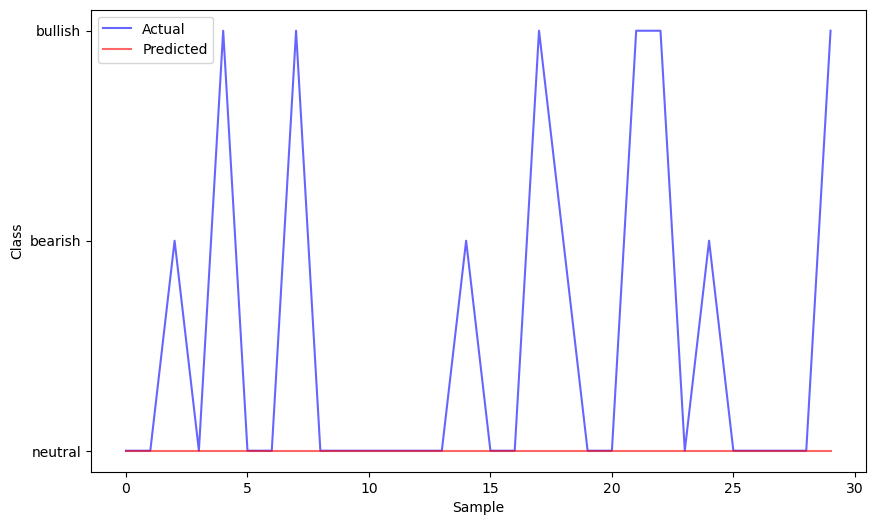

In [14]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Plot the predictions vs actual for visual comparison
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label="Actual", color="blue", alpha=0.6)
plt.plot(y_pred, label="Predicted", color="red", alpha=0.6)
plt.xlabel("Sample")
plt.ylabel("Class")
plt.legend()
plt.show()

Train RMSE: 2.803146013183246
Test RMSE: 2.005940892211773


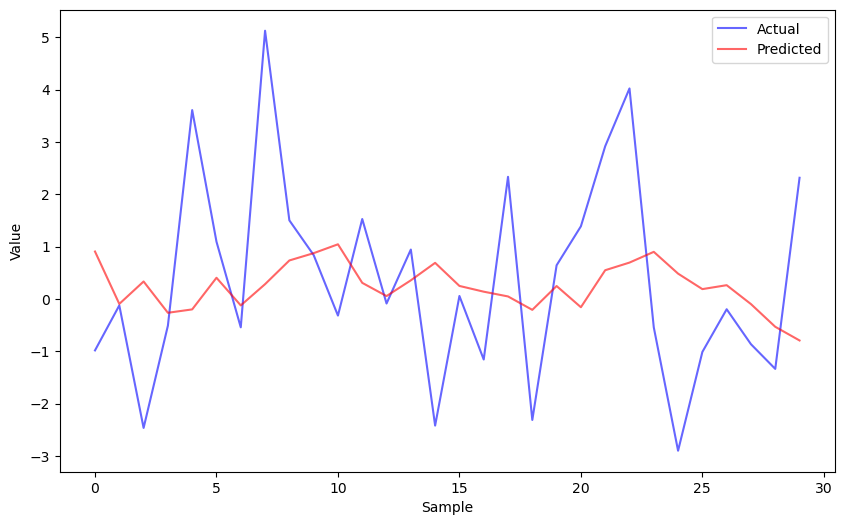

In [11]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Assume X_train, X_test, y_train, y_test are your prepared datasets

# Initialize the XGBoost model with some parameters
xgb_model = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    alpha=1,
    random_state=42
)

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions
train_pred = xgb_model.predict(X_train)
test_pred = xgb_model.predict(X_test)

# Evaluate the model
train_mse = mean_squared_error(y_train, train_pred, squared=False)
test_mse = mean_squared_error(y_test, test_pred, squared=False)

print(f"Train RMSE: {train_mse}")
print(f"Test RMSE: {test_mse}")

# Plotting predictions
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label="Actual", color="blue", alpha=0.6)
plt.plot(test_pred, label="Predicted", color="red", alpha=0.6)
plt.xlabel("Sample")
plt.ylabel("Value")
plt.legend()
plt.show()


In [15]:
y_pred

array(['neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral',
       'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral',
       'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral',
       'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral',
       'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral'],
      dtype=object)

<Figure size 1000x800 with 0 Axes>

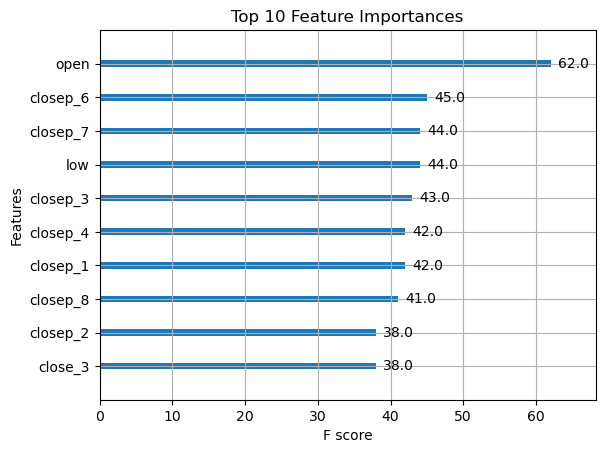

In [12]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

# Plot feature importance
plt.figure(figsize=(10, 8))
plot_importance(xgb_model, importance_type='weight', max_num_features=10)
plt.title("Top 10 Feature Importances")
plt.show()